In [1]:
# import modules
import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [2]:
dat_pred = pd.read_csv('Beijing2015.csv')
dat_pred.head()

,Unnamed: 0,No,year,month,day,hour,season,AQI,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,43824,43825,2015,1,1,0,4,114.0,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
1,43825,43826,2015,1,1,1,4,104.0,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
2,43826,43827,2015,1,1,2,4,92.0,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
3,43827,43828,2015,1,1,3,4,64.0,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
4,43828,43829,2015,1,1,4,4,48.0,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0


In [3]:
dat_pred['cbwd'].replace('SE',0,inplace=True)
dat_pred['cbwd'].replace('NW',1,inplace=True)
dat_pred['cbwd'].replace('NE',2,inplace=True)
dat_pred['cbwd'].replace('cv',3,inplace=True)

In [4]:
# Transform the variables season, month and combined wind direction into string
dat_pred.season = dat_pred.season.astype('str')
dat_pred.month = dat_pred.month.astype('str')
dat_pred.cbwd = dat_pred.cbwd.astype('str')
dat_pred.year = dat_pred.year.astype('str')

Create the design matric, X include month, season, humidity, temperature, combined wind direction, combined wind speed, precipitation, cumulative precipitation

In [5]:
# Create the design matrix
y, X = dmatrices('AQI ~  0 + year + month + season + HUMI + TEMP'+ 
                 '+ cbwd + Iws + precipitation + Iprec ',
                 data=dat_pred,
                 return_type='dataframe')

Normalize the datasets. Split the datasets into 30% test data and 70% training data. 

In [6]:
# Normalize the X and Y variables
X_scale = preprocessing.MinMaxScaler().fit_transform(X)
y_scale = preprocessing.MinMaxScaler().fit_transform(y)

In [7]:
# 30-70% simple split
# To make the result reproducible, set the random_state
train_y,test_y,train_X,test_X = model_selection.train_test_split(y, X,
                                                                 test_size=0.3,
                                                                 random_state=123)

In [8]:
# 30-70% simple split for the scaled data
# To make the result reproducible, set the random_state
train_y_scale,test_y_scale,train_X_scale,test_X_scale = model_selection.train_test_split(y_scale, X_scale,
                                                                 test_size=0.3,
                                                                 random_state=123)

In [9]:
train_X.shape

(5160, 23)

In [10]:
train_y.shape

(5160, 1)

## Predictive Modeling

In the predictive modelding part, K-Nearest Neighbors, regression tree, neural network and random forest will be utilized in order to predict the Air Quality Index. 

## K-Nearest Neighbors

In [11]:
# tune the parameters using the GridSearchCV
knn = KNeighborsRegressor()

params = {'n_neighbors': np.arange(1,31),
          'weights':['uniform'],
          'algorithm':['auto']}

model_knn = GridSearchCV(knn, param_grid = params)

# fit the model
model_knn.fit(train_X_scale,train_y_scale)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), 'weights': ['uniform'], 'algorithm': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [12]:
 model_knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}

In [13]:
knn_final = neighbors.KNeighborsRegressor(n_neighbors = 7,
                                     weights = 'uniform',
                                     algorithm = 'auto')

knn_final.fit(train_X,train_y_s)
pred_y_knnfinal = knn_final.predict(test_X_scale)

In [14]:
# Import the matplotlib.pyplot
import matplotlib.pyplot as plt

# Enable inline plotting in notebook
%matplotlib inline

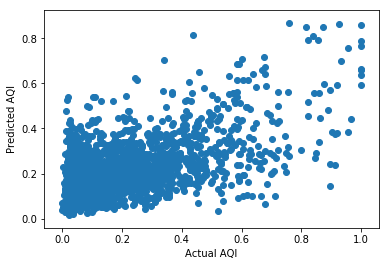

In [15]:
plt.scatter(test_y_scale, pred_y_knnfinal)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')

In [16]:
# Calculate MAE
metrics.mean_absolute_error(test_y, pred_y_knnfinal)

111.82546486378325

In [17]:
# Calculate MSE
metrics.regression.mean_squared_error(test_y, pred_y_knnfinal)

20480.033762540752

In [19]:
# Calculate R squared
metrics.r2_score(test_y_scale, pred_y_knnfinal)

0.33375431086665441

## Regression Tree

In [40]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [41]:
# initial model
tree = DecisionTreeRegressor()

params = {'min_samples_split': np.arange(2,81)}

model_tree = GridSearchCV(tree, param_grid=params)

# fit the model
model_tree.fit(train_X,train_y)

#prediction
prediction_tree = model_tree.predict(test_X)

In [42]:
 model_tree.best_params_

{'min_samples_split': 80}

In [43]:
tree_final = DecisionTreeRegressor(min_samples_split = 80)
tree_final.fit(train_X,train_y)
pred_y_treefinal = tree_final.predict(test_X)

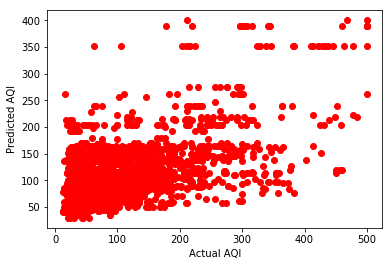

In [44]:
plt.scatter(test_y, pred_y_treefinal, color = 'red')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')

In [45]:
# Calculate MAE
metrics.mean_absolute_error(test_y, pred_y_treefinal)

55.403142499543783

In [46]:
# Calculate MSE
metrics.regression.mean_squared_error(test_y, pred_y_treefinal)

5655.6275209650457

In [47]:
# Calculate R squared
metrics.r2_score(test_y, pred_y_treefinal)

0.29197665838146358

## Neural Network 

In [48]:
from sklearn.neural_network import MLPRegressor

In [49]:
import warnings
warnings.filterwarnings('ignore')
# initial model
ann = MLPRegressor()

# tune the hyperparameter
params = {'hidden_layer_sizes':[(300,), (250,), (200,), 
                     (150,),  (100,), (50,), (50,10), (9,7,5,3)]}

model_ann = GridSearchCV(ann, param_grid=params)

# fit the model
model_ann.fit(train_X_scale,train_y_scale)

# prediction
prediction_ann = model_ann.predict(test_X_scale)

In [50]:
model_ann.best_params_

{'hidden_layer_sizes': (300,)}

In [51]:
ann_final = MLPRegressor(hidden_layer_sizes =(300,))
ann_final.fit(train_X_scale,train_y_scale)
pred_y_annfinal = ann_final.predict(test_X_scale)

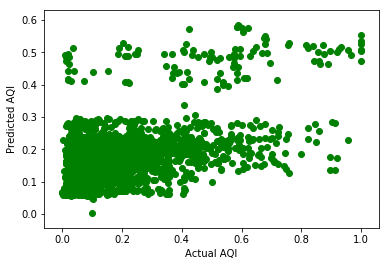

In [53]:
plt.scatter(test_y_scale, pred_y_annfinal, color = 'green')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')

In [80]:
# Calculate MAE
metrics.mean_absolute_error(test_y_scale, pred_y_annfinal)

0.11754624892640628

In [54]:
# Calculate MSE
metrics.regression.mean_squared_error(test_y_scale, pred_y_annfinal)

0.026274462856991601

In [56]:
# Calculate R squared
metrics.r2_score(test_y_scale, pred_y_annfinal)

0.21667810373944985

## Random Foreset

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
rf = RandomForestRegressor(n_estimators=5, max_features=10, random_state=123)

In [59]:
rf.fit(train_X,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=5, n_jobs=1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [60]:
# Show feature importance
rf.feature_importances_

array([ 0.00780326,  0.00484556,  0.10639225,  0.001959  ,  0.00910149,
        0.00771608,  0.00466666,  0.00460584,  0.00599993,  0.00300541,
        0.01276056,  0.00405934,  0.00808381,  0.00754652,  0.01016253,
        0.02360167,  0.02163782,  0.23880955,  0.2700839 ,  0.23380975,
        0.00651931,  0.00682977])

In [62]:
# Beautify the display of feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = train_X.columns,
                                   columns=['importance'])
feature_importances = feature_importances.sort_values('importance',ascending=False)

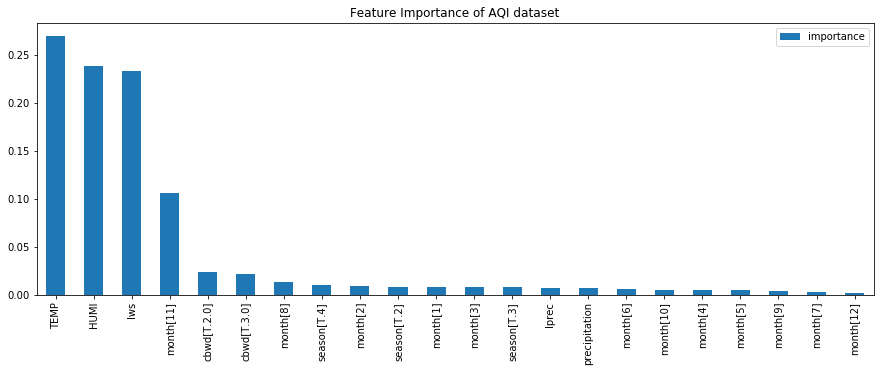

In [63]:
feature_importances.plot(kind = 'bar',figsize=(15,5),
                         title='Feature Importance of AQI dataset')

In [67]:
rf2 = RandomForestRegressor()

parameters = {'n_estimators':[10,50,80,100,200,300,400,500],
              'max_features':[1,2,3,4,5,10],
              'random_state':[123]}

grid_rf = model_selection.GridSearchCV(rf2, parameters)

grid_rf.fit(train_X,train_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 80, 100, 200, 300, 400, 500], 'max_features': [1, 2, 3, 4, 5, 10], 'random_state': [123]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [68]:
# Show best parameters
grid_rf.best_params_

{'max_features': 10, 'n_estimators': 400, 'random_state': 123}

In [70]:
# Train a new RF with best parameters
rf_final = RandomForestRegressor(n_estimators=400, 
                                  max_features=10, 
                                  random_state=123)

In [74]:
# Predict on test set
pred_y_rffinal = rf_final.predict(test_X)

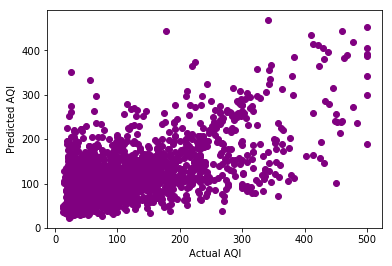

In [75]:
plt.scatter(test_y, pred_y_rffinal, color = 'purple')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')

In [81]:
# Calculate MAE
metrics.mean_absolute_error(test_y, pred_y_rffinal)

50.814509847756597

In [77]:
# Calculate MSE
metrics.regression.mean_squared_error(test_y, pred_y_rffinal)

5054.1607750973653

In [79]:
# Calculate R squared
metrics.r2_score(test_y, pred_y_rffinal)

0.36727378389106513

## Evaluation

In [84]:
para = [model_knn.best_params_,
            model_tree.best_params_,
            model_ann.best_params_,
            grid_rf.best_params_]

mae = [metrics.mean_absolute_error(test_y_scale, pred_y_knnfinal),
       metrics.mean_absolute_error(test_y, pred_y_treefinal),
       metrics.mean_absolute_error(test_y_scale, pred_y_annfinal),
       metrics.mean_absolute_error(test_y, pred_y_rffinal)]

mse = [metrics.regression.mean_squared_error(test_y_scale, pred_y_knnfinal),
       metrics.regression.mean_squared_error(test_y, pred_y_treefinal),
       metrics.regression.mean_squared_error(test_y_scale, pred_y_annfinal),
       metrics.regression.mean_squared_error(test_y, pred_y_rffinal)]

r2 = [metrics.r2_score(test_y_scale, pred_y_knnfinal),
      metrics.r2_score(test_y, pred_y_treefinal),
      metrics.r2_score(test_y_scale, pred_y_annfinal),
      metrics.r2_score(test_y, pred_y_rffinal)]

In [86]:
pd.DataFrame({'Mean Absolute Error':mae, 'Mean Square Error':mse, 'R Squared':r2, 'Parameters':para},
             index = ['K-Nearest Neighbors','Regression Tree','Neural Network','Random Foreset'])

,Mean Absolute Error,Mean Square Error,Parameters,R Squared
K-Nearest Neighbors,0.108763,0.023143,"{'algorithm': 'auto', 'n_neighbors': 7, 'weigh...",0.310037
Regression Tree,55.403142,5655.627521,{'min_samples_split': 80},0.291977
Neural Network,0.117546,0.026274,"{'hidden_layer_sizes': (300,)}",0.216678
Random Foreset,50.814510,5054.160775,"{'max_features': 10, 'n_estimators': 400, 'ran...",0.367274
